In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
from scipy.stats import shapiro
from scipy.stats import wilcoxon


In [68]:

df_netflix = pd.read_csv('sample_data/netflix_titles.csv', on_bad_lines='skip')
df_rt = pd.read_csv('sample_data/rotten_tomatoes_movies.csv', on_bad_lines='skip')
imdb_ratings = pd.read_csv('sample_data/title.ratings.tsv', sep='\t', on_bad_lines='skip')
imdb_basics = pd.read_csv('sample_data/title.basics.tsv', sep='\t', on_bad_lines='skip', low_memory=False)


imdb_basics_films = imdb_basics[imdb_basics['titleType'] == 'movie'][['tconst', 'primaryTitle', 'startYear', 'genres']]
imdb_basics_films['primaryTitle'] = imdb_basics_films['primaryTitle'].str.lower()  
imdb_basics_films['startYear'] = pd.to_numeric(imdb_basics_films['startYear'], errors='coerce')  


imdb_combined = pd.merge(imdb_basics_films, imdb_ratings, on='tconst', how='inner')


df_rt['movie_title_lower'] = df_rt['movie_title'].str.lower()
df_rt['original_release_date'] = pd.to_datetime(df_rt['original_release_date'], errors='coerce')
df_rt['year'] = df_rt['original_release_date'].dt.year


df_netflix['title_lower'] = df_netflix['title'].str.lower()
df_netflix['release_year'] = pd.to_numeric(df_netflix['release_year'], errors='coerce')


df_netflix_horror = df_netflix[df_netflix['listed_in'].str.contains('Horror', case=False, na=False)].copy()
df_rt_horror = df_rt[df_rt['genres'].str.contains('Horror', case=False, na=False)].copy()
imdb_horror = imdb_combined[imdb_combined['genres'].str.contains('Horror', case=False, na=False)].copy()


netflix_rt_merged = pd.merge(df_netflix_horror, df_rt_horror, left_on=['title_lower', 'release_year'],
                             right_on=['movie_title_lower', 'year'], how='inner', suffixes=('_netflix', '_rt'))


netflix_rt_merged = netflix_rt_merged.drop_duplicates(subset=['title_lower', 'release_year'])


horror_df = pd.merge(netflix_rt_merged, imdb_horror, left_on=['title_lower', 'release_year'],
                     right_on=['primaryTitle', 'startYear'], how='inner', suffixes=('', '_imdb'))


horror_df = horror_df.drop_duplicates(subset=['title_lower', 'release_year'])


ratings_df = horror_df[['title_lower', 'release_year', 'rating', 'tomatometer_rating', 'audience_rating', 'averageRating', 'numVotes']].copy()


ratings_df = ratings_df.rename(columns={
    'rating': 'Netflix_Rating',
    'tomatometer_rating': 'RottenTomatoes_Critic_Rating',
    'audience_rating': 'RottenTomatoes_Audience_Rating',
    'averageRating': 'IMDb_Rating',
    'numVotes': 'IMDb_NumVotes'
})

print("Combined Ratings DataFrame:")
print(ratings_df.head())  


Combined Ratings DataFrame:
                                        title_lower  release_year  \
0                                        dark skies          2013   
1                                            jaws 2          1978   
2                                 jaws: the revenge          1987   
3  the haunting in connecticut 2: ghosts of georgia          2013   
4                                     the strangers          2008   

  Netflix_Rating  RottenTomatoes_Critic_Rating  \
0          PG-13                          41.0   
1             PG                          58.0   
2          PG-13                           0.0   
3              R                          19.0   
4              R                          48.0   

   RottenTomatoes_Audience_Rating  IMDb_Rating  IMDb_NumVotes  
0                            49.0          6.3          80817  
1                            38.0          5.8          86147  
2                            15.0          3.0          50481  


Colunas disponíveis no horror_df: Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'title_lower', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'movie_title_lower', 'year', 'tconst', 'primaryTitle', 'startYear',
       'genres_imdb', 'averageRating', 'numVotes'],
      dtype='object')
Exemplo de dados em 'all_genres': 0                        [Horror,  Mystery & Suspense]
1    [Action & Adventure,  Horror,  Mystery & Suspe...
2    [Actio

C:\Users\Micro\AppData\Local\Temp\ipykernel_8412\3625536122.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')


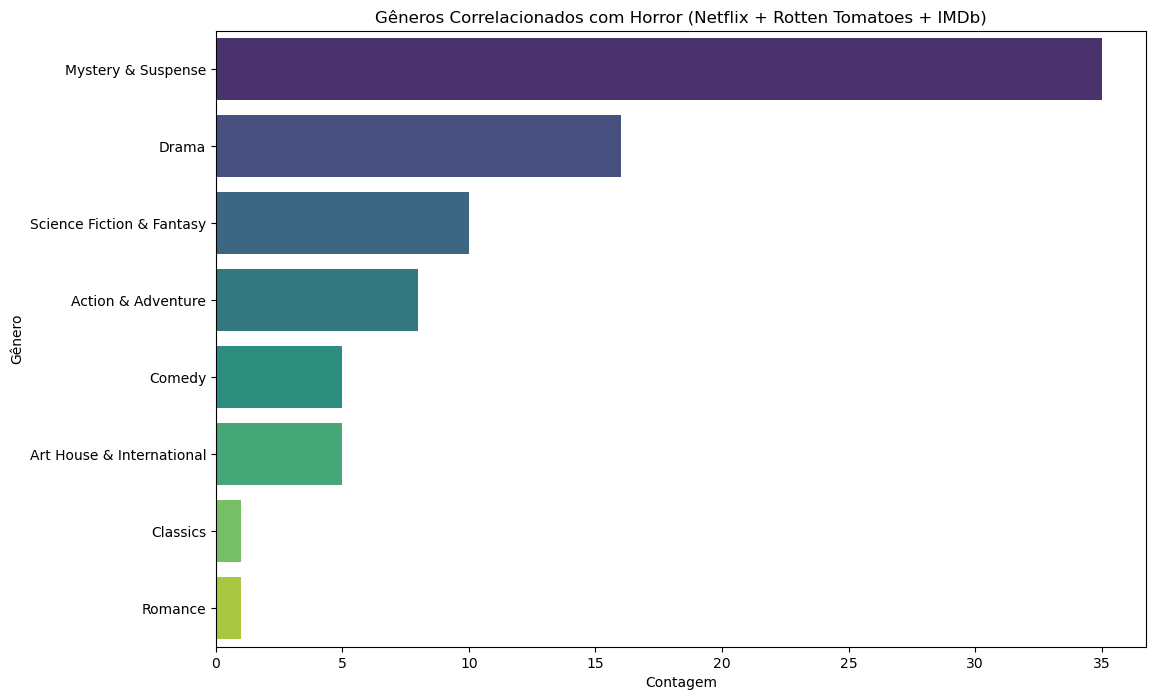

In [69]:

print("Colunas disponíveis no horror_df:", horror_df.columns)


if 'genres_netflix' in horror_df.columns and 'genres_rotten' in horror_df.columns:
    
    horror_df['all_genres'] = horror_df['genres_netflix'] + horror_df['genres_rotten']
elif 'genres' in horror_df.columns:
    
    horror_df['all_genres'] = horror_df['genres'].str.split(',')
else:
    print("Nenhuma coluna de gêneros disponível para combinar. Verifique os dados.")


print("Exemplo de dados em 'all_genres':", horror_df['all_genres'].head())


if 'all_genres' in horror_df.columns:
    horror_df.loc[:, 'genres_without_horror'] = horror_df['all_genres'].apply(lambda x: [genre.strip() for genre in x if 'Horror' not in genre])

    
    all_genres = [genre for sublist in horror_df['genres_without_horror'] for genre in sublist]
    genre_counts = Counter(all_genres)

    
    genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

    
    genre_df = genre_df[~genre_df['Genre'].str.contains('Horror', case=False, na=False)]

    
    genre_df = genre_df.sort_values(by='Count', ascending=False)

    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')
    plt.title('Gêneros Correlacionados com Horror (Netflix + Rotten Tomatoes + IMDb)')
    plt.xlabel('Contagem')
    plt.ylabel('Gênero')
    plt.show()
else:
    print("Não foi possível criar a coluna 'all_genres'. Verifique os dados.")

In [70]:

ratings_df.loc[:, 'RottenTomatoes_Critic_Rating'] = pd.to_numeric(ratings_df['RottenTomatoes_Critic_Rating'], errors='coerce')


ratings_clean_df = ratings_df.dropna(subset=['RottenTomatoes_Critic_Rating'])


highest_rated = ratings_clean_df.sort_values(by='RottenTomatoes_Critic_Rating', ascending=False).head(10)
lowest_rated = ratings_clean_df.sort_values(by='RottenTomatoes_Critic_Rating', ascending=True).head(10)

print("Filmes de Terror com as Notas Mais Altas (Rotten Tomatoes - Críticos):")
print(highest_rated[['title_lower', 'release_year', 'RottenTomatoes_Critic_Rating']])

print("\nFilmes de Terror com as Notas Mais Baixas (Rotten Tomatoes - Críticos):")
print(lowest_rated[['title_lower', 'release_year', 'RottenTomatoes_Critic_Rating']])


Filmes de Terror com as Notas Mais Altas (Rotten Tomatoes - Críticos):
         title_lower  release_year  RottenTomatoes_Critic_Rating
27           creep 2          2017                         100.0
31  under the shadow          2016                          99.0
57   rosemary's baby          1968                          96.0
72     the evil dead          1981                          95.0
19        sweetheart          2019                          95.0
38            carrie          1976                          93.0
25               cam          2018                          93.0
30       little evil          2017                          92.0
29     gerald's game          2017                          91.0
83        zombieland          2009                          89.0

Filmes de Terror com as Notas Mais Baixas (Rotten Tomatoes - Críticos):
                title_lower  release_year  RottenTomatoes_Critic_Rating
2         jaws: the revenge          1987                           0

In [71]:

all_subgenres = set([genre.strip() for genres in horror_df['all_genres'] if isinstance(genres, list) for genre in genres])
print("Subgêneros presentes no horror_df:", all_subgenres)


subgenres = ['Thriller', 'Mystery & Suspense', 'Drama', 'Science Fiction & Fantasy', 'Action & Adventure']


processed_titles = set()


for genre in subgenres:
    
    subgenre_df = horror_df[horror_df['all_genres'].apply(lambda x: any(pd.Series(x).str.contains(genre, case=False)) if isinstance(x, list) else False)]

    
    if subgenre_df.empty:
        print(f"Gênero: {genre} - Nenhum dado disponível.\n")
        continue

    
    titles = set(subgenre_df['title_lower'])

    
    titles_to_process = titles - processed_titles

    if not titles_to_process:
        print(f"Gênero: {genre} - Nenhum título único novo para processar.\n")
        continue

    
    processed_titles.update(titles_to_process)

    
    ratings_subgenre_df = ratings_df[ratings_df['title_lower'].isin(titles_to_process)].copy()

    
    if ratings_subgenre_df.empty:
        print(f"Gênero: {genre} - Nenhum dado disponível após o filtro de títulos.\n")
        continue

    
    ratings_subgenre_df.loc[:, 'RottenTomatoes_Critic_Rating'] = pd.to_numeric(ratings_subgenre_df['RottenTomatoes_Critic_Rating'], errors='coerce')
    ratings_subgenre_df.loc[:, 'RottenTomatoes_Audience_Rating'] = pd.to_numeric(ratings_subgenre_df['RottenTomatoes_Audience_Rating'], errors='coerce')

    
    ratings_subgenre_df = ratings_subgenre_df.dropna(subset=['RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating'])

    
    if ratings_subgenre_df.empty:
        print(f"Gênero: {genre} - Nenhum dado disponível após remoção de NaNs.\n")
        continue

    
    critics_mean = ratings_subgenre_df['RottenTomatoes_Critic_Rating'].mean()
    audience_mean = ratings_subgenre_df['RottenTomatoes_Audience_Rating'].mean()

    
    print(f"Gênero: {genre}")
    print(f"Nota Média dos Críticos: {critics_mean:.2f}")
    print(f"Nota Média da Audiência: {audience_mean:.2f}\n")


Subgêneros presentes no horror_df: {'Art House & International', 'Action & Adventure', 'Mystery & Suspense', 'Drama', 'Classics', 'Comedy', 'Romance', 'Science Fiction & Fantasy', 'Horror'}
Gênero: Thriller - Nenhum dado disponível.

Gênero: Mystery & Suspense
Nota Média dos Críticos: 50.23
Nota Média da Audiência: 47.86

Gênero: Drama
Nota Média dos Críticos: 50.88
Nota Média da Audiência: 44.50

Gênero: Science Fiction & Fantasy
Nota Média dos Críticos: 51.67
Nota Média da Audiência: 50.17

Gênero: Action & Adventure
Nota Média dos Críticos: 28.00
Nota Média da Audiência: 35.00



Comparação entre Avaliações dos Críticos (Rotten Tomatoes) e IMDb:
Coeficiente (Slope): 0.021129542818480573
Intercepto: 4.667280229074039
Coeficiente de Determinação (R²): 0.4275251026903286



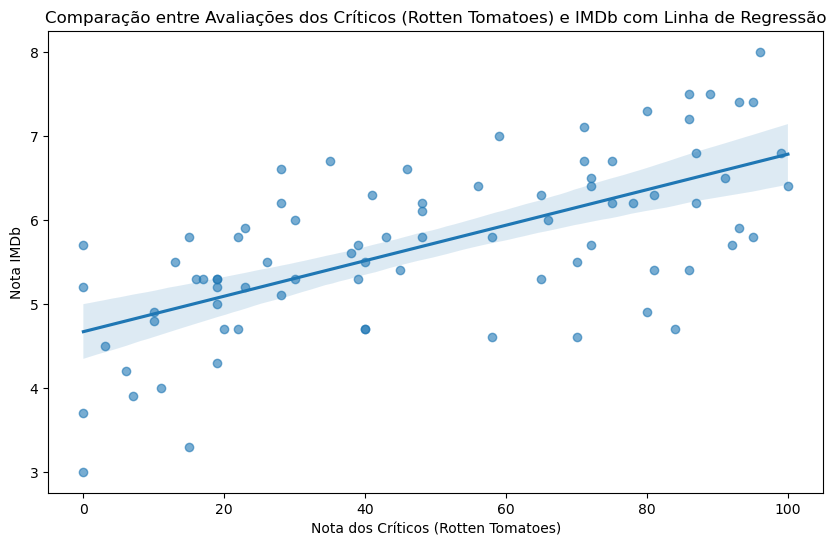

Comparação entre Avaliações da Audiência (Rotten Tomatoes) e IMDb:
Coeficiente (Slope): 0.046016941094596225
Intercepto: 3.6121324456151207
Coeficiente de Determinação (R²): 0.7967138223917185



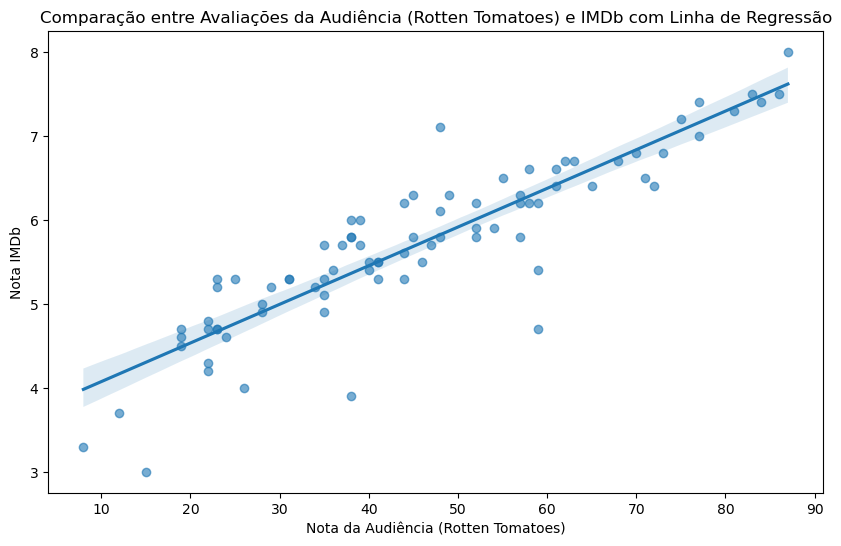

Comparação entre Avaliações dos Críticos e da Audiência (Rotten Tomatoes):
Coeficiente (Slope): 0.4034867276445512
Intercepto: 25.660687578214823
Coeficiente de Determinação (R²): 0.41435546102479337



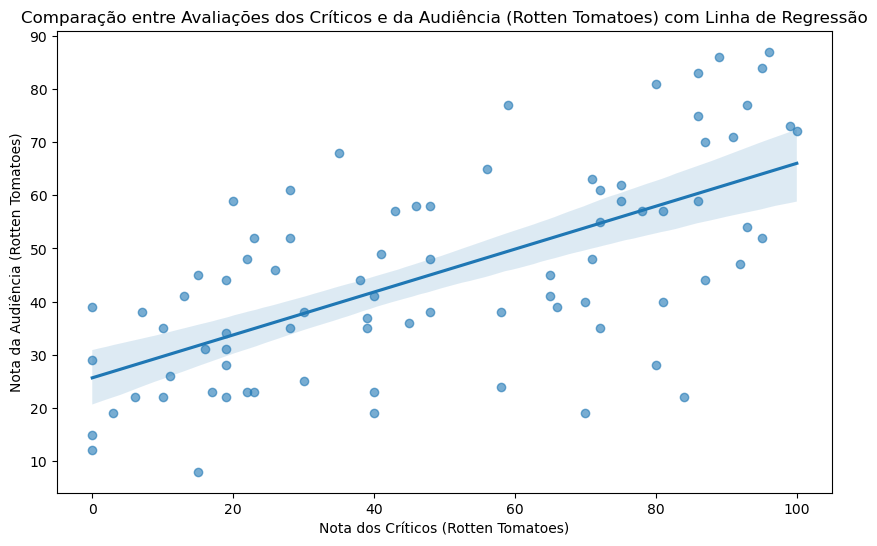

In [72]:

if 'averageRating' in ratings_df.columns:
    ratings_df['IMDb_Rating'] = pd.to_numeric(ratings_df['averageRating'], errors='coerce')
elif 'IMDb_Rating' in ratings_df.columns:
    ratings_df['IMDb_Rating'] = pd.to_numeric(ratings_df['IMDb_Rating'], errors='coerce')
else:
    print("Coluna de avaliação IMDb não encontrada no ratings_df. Verifique os dados.")
    


if 'IMDb_Rating' in ratings_df.columns and 'RottenTomatoes_Critic_Rating' in ratings_df.columns and 'RottenTomatoes_Audience_Rating' in ratings_df.columns:
    
    comparison_df = ratings_df[['RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating', 'IMDb_Rating']].dropna()

    def regress_and_plot(x_col, y_col, x_label, y_label, title):
        X = comparison_df[[x_col]].values  
        y = comparison_df[y_col].values    
        
        
        model = LinearRegression()
        model.fit(X, y)
        
        
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        
        
        print(f"{title}:")
        print(f"Coeficiente (Slope): {model.coef_[0]}")
        print(f"Intercepto: {model.intercept_}")
        print(f"Coeficiente de Determinação (R²): {r2}\n")
        
        
        plt.figure(figsize=(10, 6))
        sns.regplot(x=x_col, y=y_col, data=comparison_df, scatter_kws={'alpha':0.6})
        plt.title(f"{title} com Linha de Regressão")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.show()

    
    regress_and_plot('RottenTomatoes_Critic_Rating', 'IMDb_Rating', 'Nota dos Críticos (Rotten Tomatoes)', 'Nota IMDb',
                     'Comparação entre Avaliações dos Críticos (Rotten Tomatoes) e IMDb')

    
    regress_and_plot('RottenTomatoes_Audience_Rating', 'IMDb_Rating', 'Nota da Audiência (Rotten Tomatoes)', 'Nota IMDb',
                     'Comparação entre Avaliações da Audiência (Rotten Tomatoes) e IMDb')

    
    regress_and_plot('RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating', 'Nota dos Críticos (Rotten Tomatoes)', 'Nota da Audiência (Rotten Tomatoes)',
                     'Comparação entre Avaliações dos Críticos e da Audiência (Rotten Tomatoes)')
else:
    print("Dados insuficientes para gerar comparações. Verifique se todas as colunas de avaliação estão presentes no DataFrame.")


In [73]:

if 'RottenTomatoes_Critic_Rating' in comparison_df.columns and 'RottenTomatoes_Audience_Rating' in comparison_df.columns:
    
    shapiro_test_critics = shapiro(comparison_df['RottenTomatoes_Critic_Rating'])
    shapiro_test_audience = shapiro(comparison_df['RottenTomatoes_Audience_Rating'])
    
    
    print(f"Valor-p para normalidade das notas dos críticos (Rotten Tomatoes): {shapiro_test_critics.pvalue:.5f}")
    print(f"Valor-p para normalidade das notas da audiência (Rotten Tomatoes): {shapiro_test_audience.pvalue:.5f}")

    
    if shapiro_test_critics.pvalue < 0.05:
        print("Rejeitamos a hipótese nula. As notas dos críticos não seguem uma distribuição normal.")
    else:
        print("Não podemos rejeitar a hipótese nula. As notas dos críticos seguem uma distribuição normal.")

    
    if shapiro_test_audience.pvalue < 0.05:
        print("Rejeitamos a hipótese nula. As notas da audiência não seguem uma distribuição normal.")
    else:
        print("Não podemos rejeitar a hipótese nula. As notas da audiência seguem uma distribuição normal.")
else:
    print("As colunas de notas dos críticos e/ou audiência não estão disponíveis no DataFrame 'comparison_df'. Verifique os dados.")


Valor-p para normalidade das notas dos críticos (Rotten Tomatoes): 0.00034
Valor-p para normalidade das notas da audiência (Rotten Tomatoes): 0.08708
Rejeitamos a hipótese nula. As notas dos críticos não seguem uma distribuição normal.
Não podemos rejeitar a hipótese nula. As notas da audiência seguem uma distribuição normal.


In [74]:

if 'RottenTomatoes_Critic_Rating' in comparison_df.columns and 'RottenTomatoes_Audience_Rating' in comparison_df.columns:
    
    wilcoxon_stat, p_value = wilcoxon(comparison_df['RottenTomatoes_Critic_Rating'], comparison_df['RottenTomatoes_Audience_Rating'])

    print(f"Estatística de Wilcoxon: {wilcoxon_stat:.2f}")
    print(f"Valor-p: {p_value:.5f}")

    
    if p_value < 0.05:
        print("Rejeitamos a hipótese nula. Há uma diferença significativa entre as notas dos críticos e da audiência.")
    else:
        print("Não podemos rejeitar a hipótese nula. Não há diferença significativa entre as notas dos críticos e da audiência.")
else:
    print("As colunas de notas dos críticos e/ou audiência não estão disponíveis no DataFrame 'comparison_df'. Verifique os dados.")


Estatística de Wilcoxon: 1385.00
Valor-p: 0.25963
Não podemos rejeitar a hipótese nula. Não há diferença significativa entre as notas dos críticos e da audiência.


Outliers nas Notas dos Críticos: Series([], Name: RottenTomatoes_Critic_Rating, dtype: float64)
Outliers nas Notas da Audiência: Series([], Name: RottenTomatoes_Audience_Rating, dtype: float64)


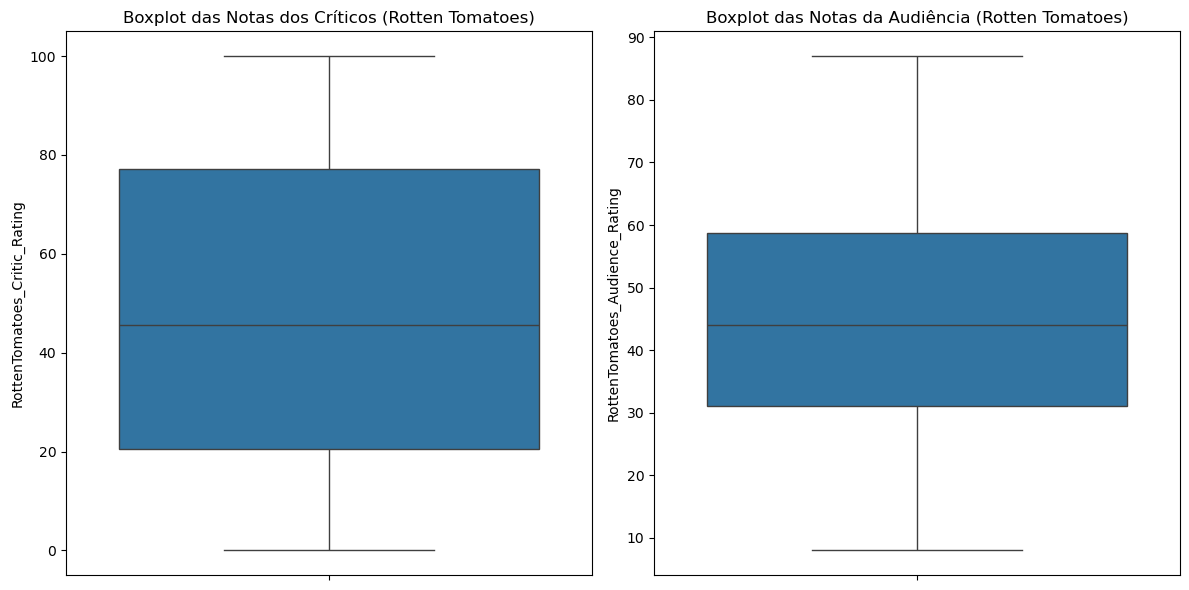

In [75]:

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]


if 'RottenTomatoes_Critic_Rating' in comparison_df.columns and 'RottenTomatoes_Audience_Rating' in comparison_df.columns:
    
    critics_outliers = detect_outliers_iqr(comparison_df['RottenTomatoes_Critic_Rating'])
    print(f"Outliers nas Notas dos Críticos: {critics_outliers}")

    
    audience_outliers = detect_outliers_iqr(comparison_df['RottenTomatoes_Audience_Rating'])
    print(f"Outliers nas Notas da Audiência: {audience_outliers}")

    
    plt.figure(figsize=(12, 6))
    
    
    plt.subplot(1, 2, 1)
    sns.boxplot(y=comparison_df['RottenTomatoes_Critic_Rating'])
    plt.title('Boxplot das Notas dos Críticos (Rotten Tomatoes)')

    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=comparison_df['RottenTomatoes_Audience_Rating'])
    plt.title('Boxplot das Notas da Audiência (Rotten Tomatoes)')

    plt.tight_layout()
    plt.show()
else:
    print("As colunas de notas dos críticos e/ou audiência não estão disponíveis no DataFrame 'comparison_df'. Verifique os dados.")

Valores ausentes antes da agregação:
RottenTomatoes_Critic_Rating      0
RottenTomatoes_Audience_Rating    0
IMDb_Rating_100                   0
dtype: int64
   Decade  Avg_Critic_Rating  Avg_Audience_Rating  Avg_IMDb_Rating
0  1960.0          96.000000            87.000000        80.000000
1  1970.0          59.666667            55.666667        64.666667
2  1980.0          60.250000            55.250000        58.250000
3  1990.0          65.200000            64.000000        66.400000
4  2000.0          41.375000            51.625000        60.062500
5  2010.0          47.692308            39.653846        54.250000
6  2020.0          38.000000            44.000000        56.000000


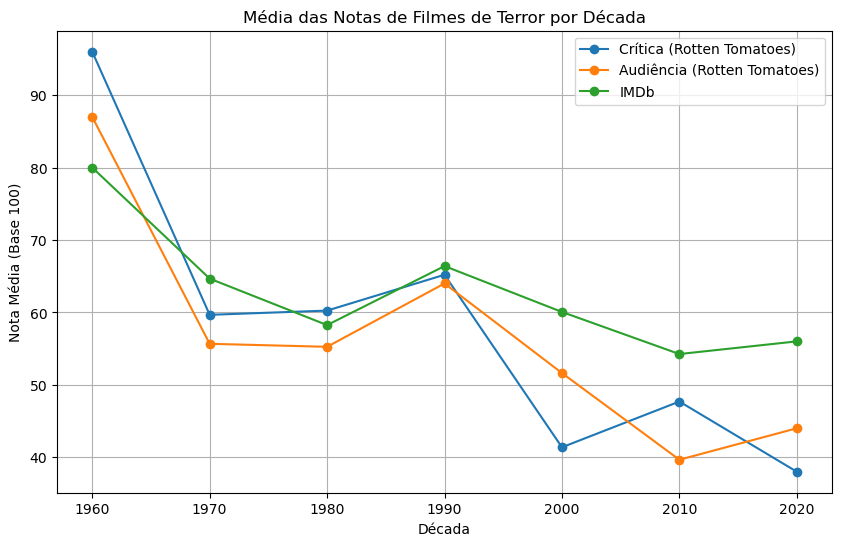

In [76]:

if 'averageRating' in horror_df.columns:
    horror_df['IMDb_Rating_100'] = horror_df['averageRating'] * 10  
else:
    print("Coluna 'averageRating' não encontrada. Verifique o nome da coluna.")


if 'tomatometer_rating' in horror_df.columns and 'audience_rating' in horror_df.columns:
    horror_df['RottenTomatoes_Critic_Rating'] = horror_df['tomatometer_rating']
    horror_df['RottenTomatoes_Audience_Rating'] = horror_df['audience_rating']
else:
    print("Colunas de Rotten Tomatoes não encontradas. Verifique os nomes das colunas.")


if 'startYear' in horror_df.columns:
    
    horror_df['decade'] = (horror_df['startYear'] // 10) * 10
else:
    print("Coluna 'startYear' não encontrada. Usando 'release_year' para definir a década.")
    horror_df['decade'] = (horror_df['release_year'] // 10) * 10


print("Valores ausentes antes da agregação:")
print(horror_df[['RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating', 'IMDb_Rating_100']].isnull().sum())


decade_grouped = horror_df.groupby('decade').agg({
    'RottenTomatoes_Critic_Rating': 'mean',
    'RottenTomatoes_Audience_Rating': 'mean',
    'IMDb_Rating_100': 'mean'
}).reset_index()


decade_grouped.columns = ['Decade', 'Avg_Critic_Rating', 'Avg_Audience_Rating', 'Avg_IMDb_Rating']


print(decade_grouped)


plt.figure(figsize=(10, 6))


plt.plot(decade_grouped['Decade'], decade_grouped['Avg_Critic_Rating'], label='Crítica (Rotten Tomatoes)', marker='o')
plt.plot(decade_grouped['Decade'], decade_grouped['Avg_Audience_Rating'], label='Audiência (Rotten Tomatoes)', marker='o')
plt.plot(decade_grouped['Decade'], decade_grouped['Avg_IMDb_Rating'], label='IMDb', marker='o')


plt.title('Média das Notas de Filmes de Terror por Década')
plt.xlabel('Década')
plt.ylabel('Nota Média (Base 100)')
plt.legend()
plt.grid(True)
plt.xticks(decade_grouped['Decade'])


plt.show()


Média das Avaliações por País (Ordenado):
           Country  Avg_Critic_Rating  Avg_Audience_Rating
0             Iran          99.000000            73.000000
1           Jordan          99.000000            73.000000
2            Qatar          99.000000            73.000000
3           Mexico          72.000000            55.000000
4         Thailand          59.000000            77.000000
5   United Kingdom          53.000000            51.545455
6    United States          47.866667            45.306667
7          Ireland          40.000000            23.000000
8           Canada          38.823529            39.176471
9           France          29.750000            40.750000
10         Germany          28.500000            41.000000
11           China          24.500000            30.000000
12  Czech Republic          19.000000            34.000000
13           Spain          15.000000            45.000000
14          Norway           0.000000            29.000000


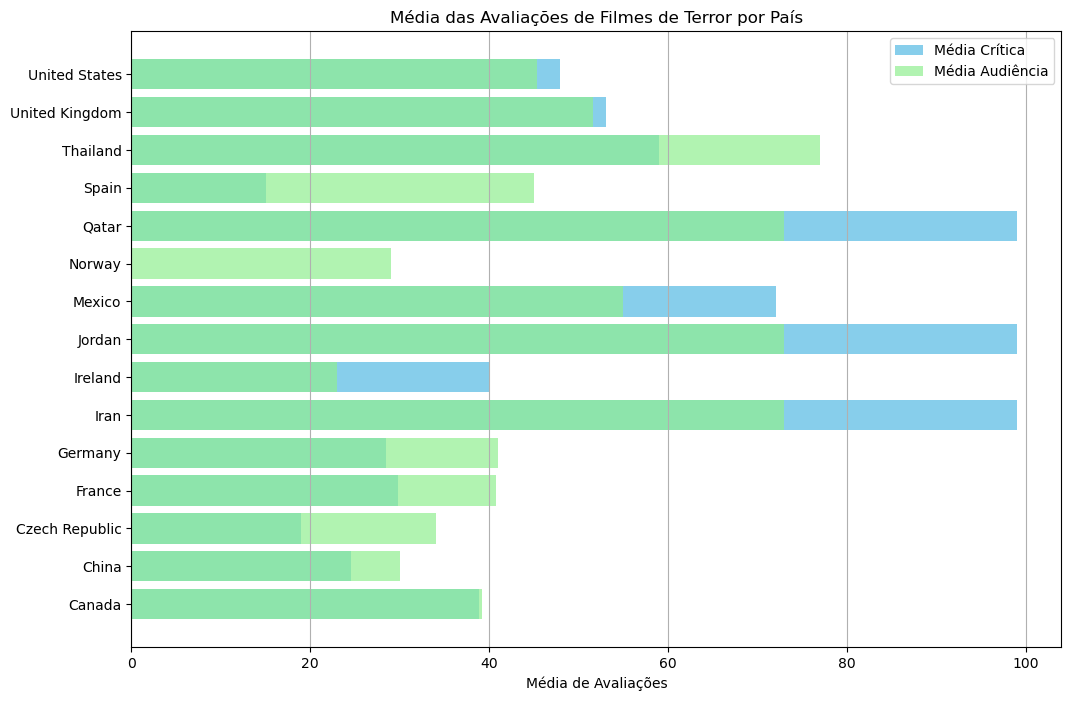

In [77]:

if 'country' in horror_df.columns and 'RottenTomatoes_Critic_Rating' in horror_df.columns and 'RottenTomatoes_Audience_Rating' in horror_df.columns:
    
    
    horror_df_expanded = horror_df.copy()
    horror_df_expanded['country'] = horror_df_expanded['country'].str.split(', ')
    
    
    horror_df_expanded = horror_df_expanded.explode('country')
    
    
    region_grouped = horror_df_expanded.groupby('country').agg({
        'RottenTomatoes_Critic_Rating': 'mean',
        'RottenTomatoes_Audience_Rating': 'mean'
    }).reset_index()
    
    
    region_grouped.columns = ['Country', 'Avg_Critic_Rating', 'Avg_Audience_Rating']
    
    

       
    sorted_region_grouped = region_grouped.sort_values(by=['Avg_Critic_Rating', 'Avg_Audience_Rating'], ascending=[False, False]).reset_index(drop=True)
    
    
    print("Média das Avaliações por País (Ordenado):")
    print(sorted_region_grouped)
    
    
    plt.figure(figsize=(12, 8))
    
    
    plt.barh(region_grouped['Country'], region_grouped['Avg_Critic_Rating'], color='skyblue', label='Média Crítica')
    
    
    plt.barh(region_grouped['Country'], region_grouped['Avg_Audience_Rating'], color='lightgreen', alpha=0.7, label='Média Audiência')
    
    
    plt.xlabel('Média de Avaliações')
    plt.title('Média das Avaliações de Filmes de Terror por País')
    plt.legend()
    plt.grid(axis='x')

    

        
        
    plt.show()
else:
    print("Colunas necessárias não encontradas. Verifique os nomes das colunas.")


In [78]:

films_1990s = horror_df[horror_df['decade'] == 1990]


top_films_1990s = films_1990s.sort_values(by='RottenTomatoes_Critic_Rating', ascending=False)


top_3_films_1990s = top_films_1990s[['title_lower', 'release_year', 'RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating', 'IMDb_Rating_100', 'genres']].head(3)

print("Top 3 Filmes de Terror da Década de 1990 com Melhores Notas:")
print(top_3_films_1990s)


Top 3 Filmes de Terror da Década de 1990 com Melhores Notas:
   title_lower  release_year  RottenTomatoes_Critic_Rating  \
79     tremors          1990                          86.0   
58    scream 2          1997                          81.0   
37    candyman          1992                          75.0   

    RottenTomatoes_Audience_Rating  IMDb_Rating_100  \
79                            75.0             72.0   
58                            57.0             63.0   
37                            62.0             67.0   

                                genres  
79                      Comedy, Horror  
58  Comedy, Horror, Mystery & Suspense  
37                              Horror  


In [79]:

directors_avg_ratings = horror_df.groupby('directors').agg({
    'RottenTomatoes_Critic_Rating': 'mean',
    'RottenTomatoes_Audience_Rating': 'mean'
}).reset_index()


directors_avg_ratings.columns = ['Director', 'Avg_Critic_Rating', 'Avg_Audience_Rating']


top_directors_critic = directors_avg_ratings.sort_values(by='Avg_Critic_Rating', ascending=False).head(10)


top_directors_audience = directors_avg_ratings.sort_values(by='Avg_Audience_Rating', ascending=False).head(10)


directors_avg_ratings['Discrepancy'] = abs(directors_avg_ratings['Avg_Critic_Rating'] - directors_avg_ratings['Avg_Audience_Rating'])


top_discrepancy_directors = directors_avg_ratings.sort_values(by='Discrepancy', ascending=False).head(10)


print("Top 10 Diretores com Melhores Médias de Avaliações dos Críticos:")
print(top_directors_critic)

print("\nTop 10 Diretores com Melhores Médias de Avaliações da Audiência:")
print(top_directors_audience)

print("\nTop 10 Diretores com Maior Discrepância Entre Avaliações dos Críticos e da Audiência:")
print(top_discrepancy_directors)


Top 10 Diretores com Melhores Médias de Avaliações dos Críticos:
            Director  Avg_Critic_Rating  Avg_Audience_Rating
51     Patrick Brice              100.0                 72.0
4       Babak Anvari               99.0                 73.0
55    Roman Polanski               96.0                 87.0
27      J.D. Dillard               95.0                 52.0
59         Sam Raimi               95.0                 84.0
9      Brian DePalma               93.0                 77.0
12  Daniel Goldhaber               93.0                 54.0
17         Eli Craig               92.0                 47.0
46     Mike Flanagan               91.0                 71.0
58   Ruben Fleischer               89.0                 86.0

Top 10 Diretores com Melhores Médias de Avaliações da Audiência:
                                    Director  Avg_Critic_Rating  \
55                            Roman Polanski               96.0   
58                           Ruben Fleischer               89.0 

In [80]:

if 'RottenTomatoes_Critic_Rating' in horror_df.columns and 'RottenTomatoes_Audience_Rating' in horror_df.columns:
    
    horror_df['Rating_Difference'] = horror_df['RottenTomatoes_Audience_Rating'] - horror_df['RottenTomatoes_Critic_Rating']
    
 
    low_critic_threshold = 50  
    high_audience_threshold = 50  
    
    
    filtered_films = horror_df[
        (horror_df['RottenTomatoes_Critic_Rating'] <= low_critic_threshold) &
        (horror_df['RottenTomatoes_Audience_Rating'] >= high_audience_threshold)
    ]
    
    
    top_films_audience = filtered_films.sort_values(by='RottenTomatoes_Audience_Rating', ascending=False)
    
    
    top_10_films_audience = top_films_audience[['title_lower', 'release_year', 'RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating', 'IMDb_Rating_100', 'genres']].head(10)
    
    print("Top Filmes com Melhores Avaliações da Audiência Apesar de Baixas Avaliações Críticas:")
    print(top_10_films_audience)
else:
    print("Colunas necessárias para a análise não encontradas. Verifique os nomes das colunas.")


Top Filmes com Melhores Avaliações da Audiência Apesar de Baixas Avaliações Críticas:
              title_lower  release_year  RottenTomatoes_Critic_Rating  \
46      final destination          2000                          35.0   
45          event horizon          1997                          28.0   
78      the vatican tapes          2015                          20.0   
47    final destination 2          2003                          48.0   
81      what lies beneath          2000                          46.0   
48    final destination 3          2006                          43.0   
63  the amityville horror          2005                          23.0   
68                the car          1977                          28.0   

    RottenTomatoes_Audience_Rating  IMDb_Rating_100  \
46                            68.0             67.0   
45                            61.0             66.0   
78                            59.0             47.0   
47                            58.0  